In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split

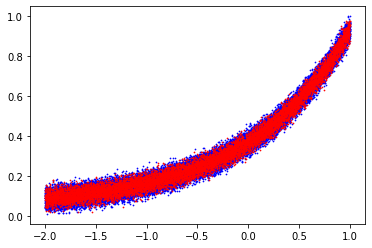

In [2]:
def gen_fn(x):
    return torch.exp(x)

def split_setup(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, random_state=42)
    return X_train.reshape(-1,1), X_val.reshape(-1,1), X_test.reshape(-1,1), y_train.reshape(-1,1), y_val.reshape(-1,1), y_test.reshape(-1,1)

X = torch.linspace(-2, 1, 2048*32)
y = (gen_fn(X) + torch.randn(2048*32, 1).T * 0.08).squeeze(0)
y = (y-torch.min(y))/(torch.max(y)-torch.min(y))


X_train, X_val, X_test, y_train, y_val, y_test = split_setup(X, y) 

plt.scatter(X_train, y_train, label='train', color='blue', s=0.5) 
plt.scatter(X_val, y_val, label='val', color='red', s=0.5)
plt.show()

In [25]:
class Exp(torch.nn.Module):
    # it needs to have at least a constructor and a forward method, just like an MLP
    def __init__(self): 
        super().__init__()
        # no additional stuff to do here 
    
    def forward(self, X):
        return torch.exp(X)

class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(1, 10, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 1),
            Exp()
        )

    def forward(self, X): 
        return self.layers(X)

Layer (type:depth-idx)                   Param #
MLP                                      --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       20
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       11
│    └─Exp: 2-4                          --
Total params: 31
Trainable params: 31
Non-trainable params: 0


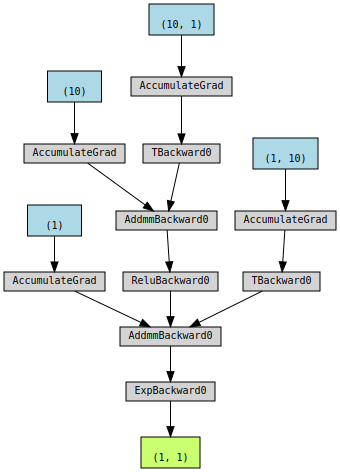

In [26]:
model = MLP()
from torchinfo import summary
from torchviz import make_dot
print(summary(model))
make_dot(model(torch.zeros(1, 1)))

In [27]:
def train_epoch(model, dataloader, loss_fn, optimizer, loss_meter, device):
    for X, y in dataloader:
        ##### MOVE DATA AND LABELS TO THE DESIRED DEVICE #####
        X = X.to(device)
        y = y.to(device)
        # 1. reset the gradients previously accumulated by the optimizer
        #    this will avoid re-using gradients from previous loops
        optimizer.zero_grad()
        # 2. get the predictions from the current state of the model
        #    this is the forward pass
        y_hat = model(X)
        # 3. calculate the loss on the current mini-batch
        loss = loss_fn(y_hat, y)
        # 4. execute the backward pass given the current loss
        loss.backward()
        # 5. update the value of the params
        optimizer.step()
        # 6. update the loss and accuracy AverageMeter
        loss_meter.update(val=loss.item(), n=X.shape[0])

def train_model(model, dataloader, loss_fn, optimizer, num_epochs, device):
    model.to(device)
    model.train()
    for epoch in range(num_epochs):
        loss_meter = AverageMeter()
        train_epoch(model, dataloader, loss_fn, optimizer, loss_meter, device)
        # now with loss meter we can print both the cumulative value and the average value
        if (epoch%100 == 0):
            print(f"Epoch {epoch+1} completed. Loss - total: {loss_meter.sum} - average: {loss_meter.avg}")
            
    # we also return the stats for the final epoch of training
    return loss_meter.sum

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0 # val holds the current stat
        self.avg = 0 # avg holds the cumulative average
        self.sum = 0 # sum holds the cumulatie value
        self.count = 0 # count holds the number of instances seen

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def test_model(model, dataloader, device, loss_fn=None, verbose=True):
    model.to(device)
    if loss_fn is not None:
        loss_meter = AverageMeter()
    model.eval() # this is the contrary of model.train() we saw before - equivalent to model.train(False)
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            y_hat = model(X)
            loss = loss_fn(y_hat, y) if loss_fn is not None else None
            if loss_fn is not None:
                loss_meter.update(loss.item(), X.shape[0])
    if (verbose):
        print(f"TESTING - loss {loss_meter.sum if loss_fn is not None else '--'}")
    return loss_meter.avg if loss_fn is not None else None

def checkpoint(model, folder_save):
    os.makedirs(folder_save, exist_ok=True)
    filename = os.path.join(folder_save, "model.pt")
    torch.save(model.state_dict(), filename)
    
def check_train_model(model, trainloader, validation_loader, loss_fn, optimizer, num_epochs, device, verbose=True):
    folder_save = "models/poisson_regression"
    best_loss = float('inf')
    model.to(device)
    model.train()
    for epoch in range(num_epochs):
        loss_meter = AverageMeter()
        train_epoch(model, trainloader, loss_fn, optimizer, loss_meter, device)
        # now with loss meter we can print both the cumulative value and the average value
        if (epoch%100 == 0):
            curr_loss = test_model(model, validation_loader, device, loss_fn, verbose=False)
            if curr_loss < best_loss:
                checkpoint(model, folder_save)
                best_loss = curr_loss
            if (verbose):
                print(f"Epoch {epoch+1} completed. Loss - total: {loss_meter.sum} - average: {loss_meter.avg}")
            
    # we also return the stats for the final epoch of training
    filename = os.path.join(folder_save, "model.pt")
    model.load_state_dict(torch.load(filename))
    return loss_eval(model, trainloader, validation_loader, device, loss_fn)
    

def loss_eval(model, trainloader, testloader, device, loss_fn):
    model.to(device)
    model.eval()
    with torch.no_grad():
        train_loss = test_model(model, trainloader, device, loss_fn, verbose=False)
        test_loss = test_model(model, testloader, device, loss_fn, verbose=False)
    return train_loss, test_loss


In [36]:
# learn_rate = 0.001 # for SGD
learn_rate = 0.1 # for Adam
num_epochs = 10000

In [42]:
loss_fn = torch.nn.PoissonNLLLoss(log_input=False)
model = MLP()
# loss_fn = torch.nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learn_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
device = "cuda:0" if torch.cuda.is_available() else "cpu"

print(f"We will use {device}")
print(model.layers[0].weight, model.layers[0].bias)

We will use cuda:0
Parameter containing:
tensor([[ 0.5454],
        [ 0.5876],
        [-0.8628],
        [-0.1158],
        [ 0.2596],
        [-0.6821],
        [ 0.6332],
        [-0.5185],
        [-0.4392],
        [ 0.5833]], requires_grad=True) Parameter containing:
tensor([-0.6723,  0.3240, -0.1377,  0.3107,  0.8924,  0.8888, -0.8030,  0.6776,
        -0.3921,  0.5918], requires_grad=True)


In [49]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader((X_train, y_train), batch_size=8, shuffle=False)
test_dataloader = DataLoader((X_val, y_val), batch_size=8, shuffle=False)
losses = check_train_model(model, train_dataloader, test_dataloader, loss_fn, optimizer, num_epochs, device, verbose=True)
print(f"Training completed, best metrics\nTRAIN LOSS: {losses[0]}\nVALIDATION LOSS: {losses[1]}")

Epoch 1 completed. Loss - total: 25825.929616451263 - average: 0.6157534122467041
Epoch 101 completed. Loss - total: 25825.73212134838 - average: 0.6157487034797668
Epoch 201 completed. Loss - total: 25825.544625997543 - average: 0.6157442331314087
Epoch 301 completed. Loss - total: 25825.36463046074 - average: 0.6157399415969849
Epoch 401 completed. Loss - total: 25825.189634799957 - average: 0.6157357692718506
Epoch 501 completed. Loss - total: 25825.02213895321 - average: 0.6157317757606506
Epoch 601 completed. Loss - total: 25824.862142920494 - average: 0.615727961063385
Epoch 701 completed. Loss - total: 25824.7071467638 - average: 0.6157242655754089
Epoch 801 completed. Loss - total: 25824.559650421143 - average: 0.6157207489013672
Epoch 901 completed. Loss - total: 25824.417153954506 - average: 0.615717351436615
Epoch 1001 completed. Loss - total: 25824.27965736389 - average: 0.6157140731811523
Epoch 1101 completed. Loss - total: 25824.14966058731 - average: 0.615710973739624
Ep

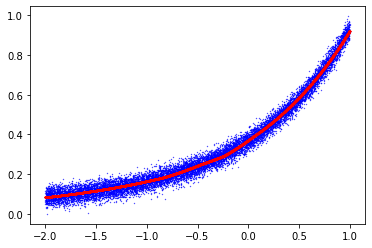

In [50]:
y_test_model = model(X_test.to(device)).to('cpu').detach().numpy()
plt.scatter(X_test, y_test, label='val', color='blue', s=0.1)
plt.scatter(X_test, y_test_model, label='val', color='red', s=0.5)
plt.show()